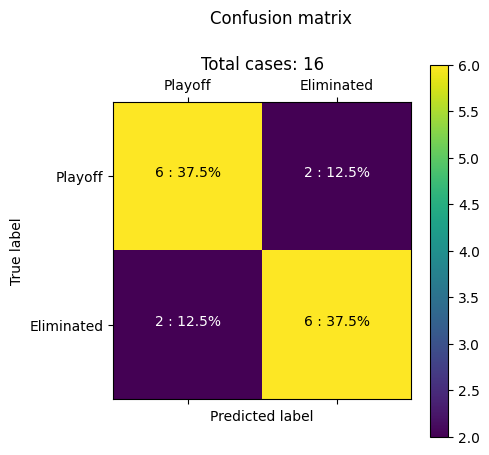

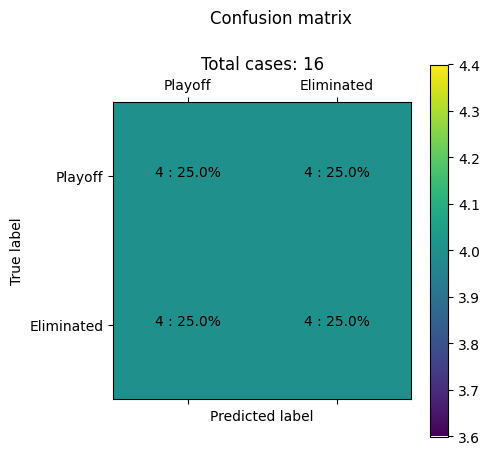

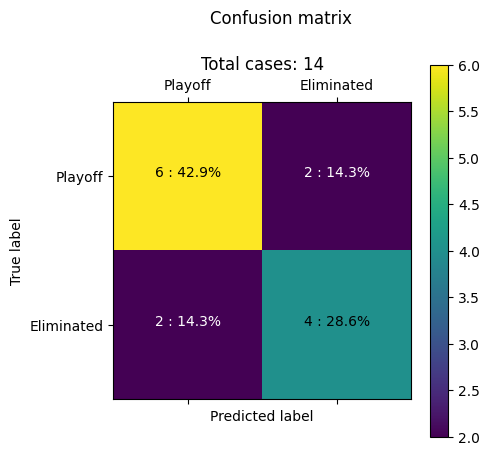

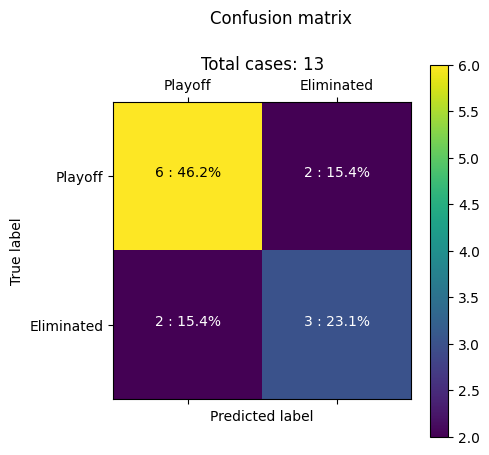

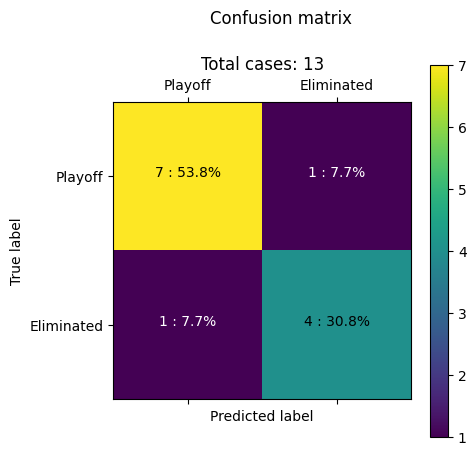

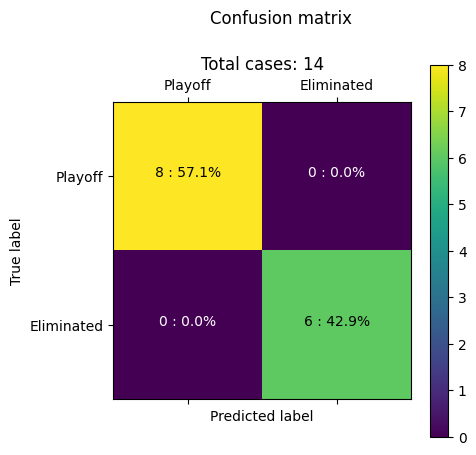

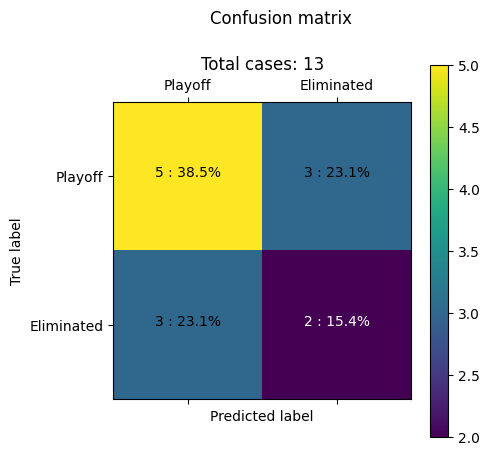

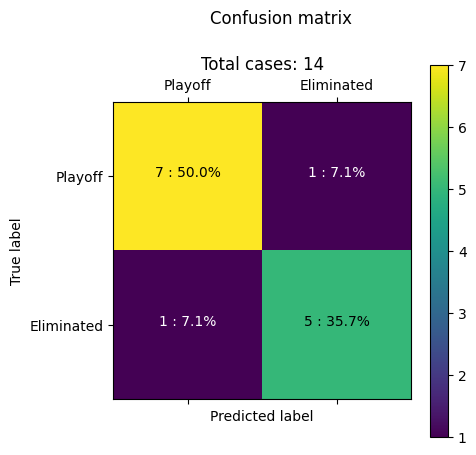

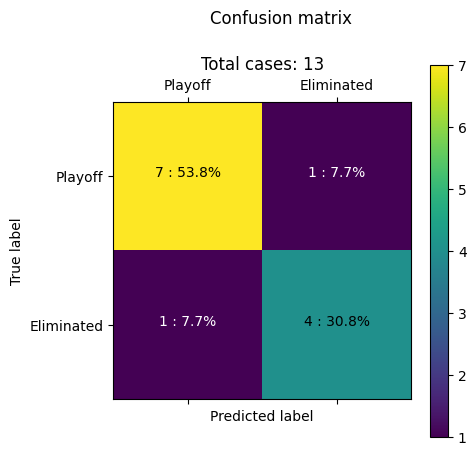

[75.0, 50.0, 71.42857142857143, 69.23076923076923, 84.61538461538461, 100.0, 53.84615384615385, 85.71428571428571, 84.61538461538461]


In [1]:
# import autosklearn.classification
from pipeline import *


# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
l = []
for i in range(2, 11):
    l.append(pipeline_year(i, False))
print(l)


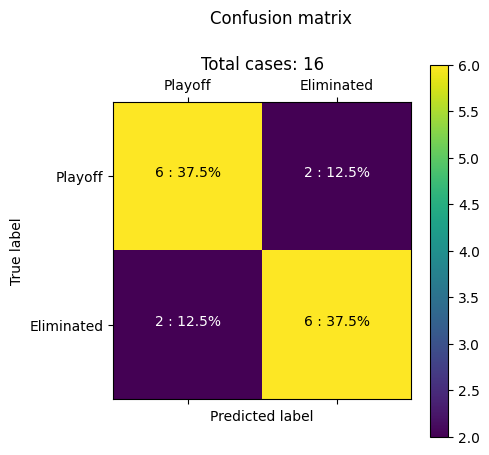

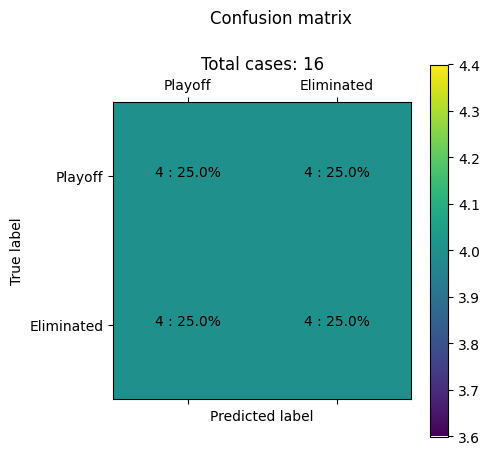

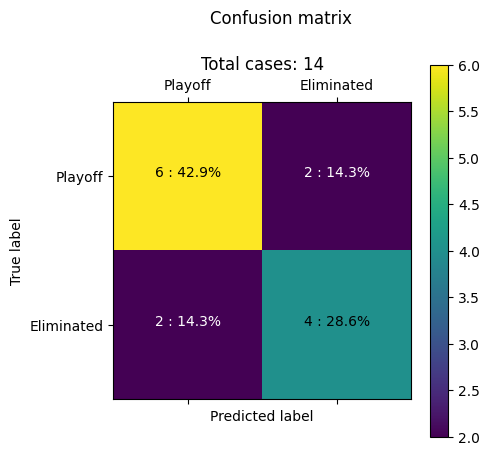

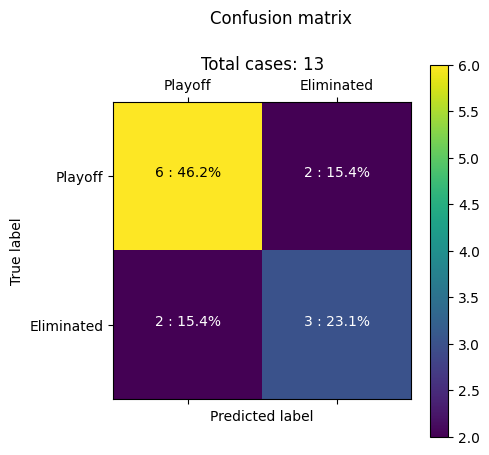

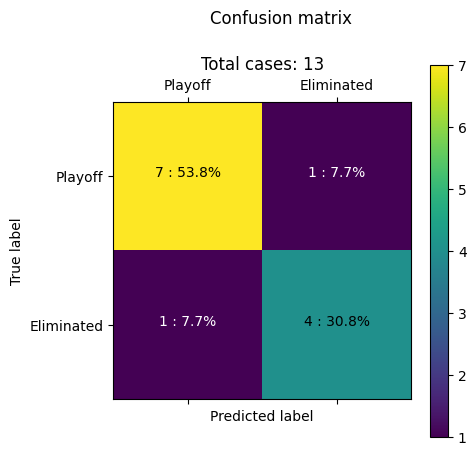

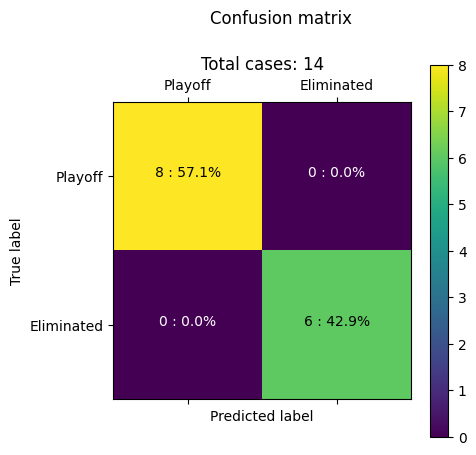

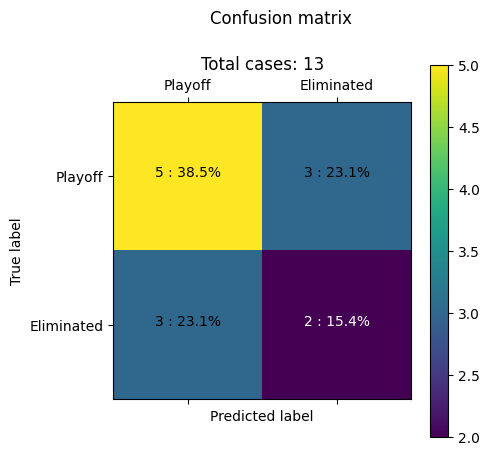

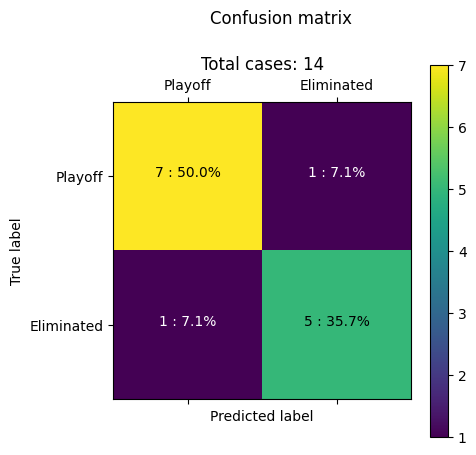

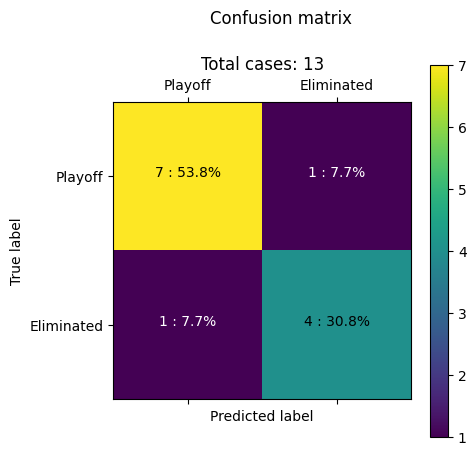

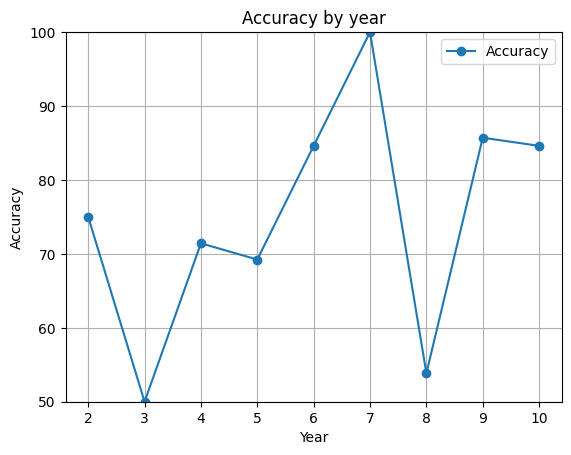

In [2]:
from pipeline import *

def check_accuracy_by_year2():
    accs = []
    years = list(range(2, 11))

    for year in years:
        acc = pipeline_year(year)
        accs.append(acc)

    # plot the accuracy line graph
    plt.plot(years, accs, label="Accuracy", marker='o', linestyle='-')

    # add labels for each data point
    # for i, acc in enumerate(accs):
      #  plt.text(years[i], acc, f"{acc:.2f}", ha="center", va="bottom")

    # add legend
    plt.legend()

    # set Y-axis limits
    plt.ylim(50, 100)

    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2()